<a href="https://colab.research.google.com/github/zahran1234/machine-learning-/blob/main/Sentiment_Analysis_features_extraction_from_word2vec150.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
from scipy import stats
from sklearn.metrics import confusion_matrix,mean_squared_error,precision_score,recall_score,f1_score ,classification_report
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from gensim.models import Word2Vec
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.stem import ARLSTem
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from keras.utils import to_categorical



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df= pd.read_excel('/content/original_dataset.xlsx')

In [ ]:
df=pd.DataFrame(df)

In [ ]:
df.head()

,Unnamed: 0,review_description,rating,company
0,0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank
1,1,ابلكيشن زباله بجد,-1,alahli_bank
2,2,سيئ التطبيق لايعمل,-1,alahli_bank
3,3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank
4,4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank


In [ ]:
print(df.shape)
df=df.dropna()
df=df.drop_duplicates()
print(df.shape)

(67127, 4)
(67125, 4)


# **data visualization**

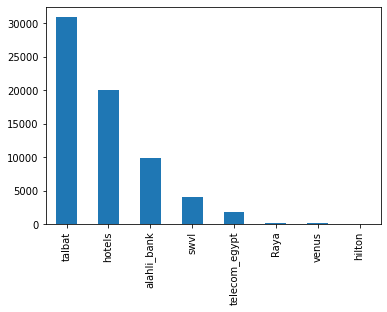

In [ ]:
df.company.value_counts().plot(kind='bar')

In [ ]:
fig = px.sunburst(df, path=['rating'],title= ' rating')
fig.update_traces(textinfo='label + percent parent')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



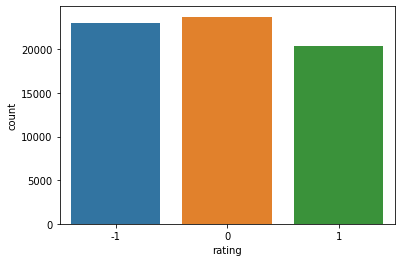

In [ ]:
sns.countplot(df.rating)

In [ ]:
fig = px.sunburst(df, path=['company', 'rating'],title= 'Relation between company and rating')
fig.update_traces(textinfo='label + percent parent')

# **data cleaning**

In [ ]:
def del_digits_and_pun(value,pun):
    new_value= re.sub('[1-9]','',value)
    for i in pun:
        new_value=new_value.replace(i,' ')
    return new_value

In [ ]:
def tokens_review(x,stop_words):
    x=str(x)
    words=word_tokenize(x)
    new_words=[]
    for i in words:
        text = re.sub(r'[^ء-ي ]',' ',i)
        
        if text not in stop_words:
            new_words.append(text)
    return new_words

delete english punctuations and arabic punctuations from our reviews

In [ ]:
arabic_punctuations = """
`÷×؛،.<>_()*&^%][ـ،/:؟.,'{}~¦+|!”…“–#.ـ
"""

english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
punctuations_list
list_pun=[i for i in punctuations_list]


df.review_description=df.review_description.apply(del_digits_and_pun,args=[list_pun])



# ** staming  reviwe**

In [ ]:
def preprossing (review):
  words=word_tokenize(review)
  new_words=[]
  stop_words=stopwords.words('arabic')
  stop_words.remove('لا')
  stop_words.remove('لكن')
  stop_words.remove('ولكن')
  stop_words.remove('واو')
  stop_words.remove('أطعم')
  stop_words.remove('أف')
  stop_words.append('طلبات')
  stop_words.append('شركه')
  stop_words.append('برنامج')
  stop_words.append('تطبيق')
  for i in words:
    stemmer = ARLSTem()
    word = stemmer.stem(i)
    if i in stop_words:
      continue 
    new_words.append(word)

  return new_words




In [ ]:
import nltk

df.steming_list=df.review_description.apply(preprossing)

<ipython-input-17-7b2250f778a7>:3: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



# **features extraction  word2vec**

In [ ]:
from gensim.models import Word2Vec
sents=[]
for i in df.steming_list:
  sents.append(i)
model=Word2Vec(sentences=sents, window=5, min_count=1, workers=4,size=100)

In [ ]:
X=np.zeros((100,), dtype=float)

for i in  df.steming_list:
  counter=0
  sum=np.zeros((100,), dtype=float)
  for x in i :
    sum+=model.wv[x]
    counter+=1
  if counter==0 :
    X=np.vstack((X,sum))
  else:
    X=np.vstack((X,sum/counter))
X= np.delete(X, (0), axis=0)
y=df.rating 
X.shape

  

(67125, 100)

In [ ]:
def get_accuracy(name, trained_model , x_train, y_train, x_test, y_test):
    tree_predict = trained_model.predict(x_test)
    print("Testing accuracy   :",metrics.accuracy_score(y_test, tree_predict)*100 , "%")
    print("MSE [TEST]          :",mean_squared_error(y_test, tree_predict))


    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :",metrics.accuracy_score(y_train, tree_predict1)*100 ,"%")
    print("MSE [TRAIN]         :",mean_squared_error(y_train, tree_predict1))

    print("precision : ",precision_score(y_test, tree_predict,average='micro'))
    print("recall    : ",recall_score(y_test, tree_predict,average='micro'))
    print("f1_score  : ",f1_score(y_test, tree_predict,average='micro'))


    cf1 = confusion_matrix(y_test,tree_predict)
    sns.heatmap(cf1,annot=True,fmt = '.0f')
    plt.xlabel('prediction')
    plt.ylabel('Actual')
    plt.title(name+ ' Confusion Matrix')
    plt.show()

    print(classification_report(y_train,  trained_model.predict(x_train)))
    print(classification_report(y_test,  trained_model.predict(x_test)))

# ** LinearSVC model** 

In [ ]:
from sklearn.model_selection import train_test_split

def encod(x):
  if x==-1:
    return 0
  if x== 0:
    return 1
  return 2
y=df.rating
y=y.apply(encod)
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.10,shuffle=True)
y_train_enc = tf.keras.utils.to_categorical(y_train)


In [ ]:

from sklearn.svm import LinearSVC
trained_clf_svc = LinearSVC().fit(x_train, y_train)


In [ ]:
get_accuracy('LinearSVC',trained_clf_svc,x_train, y_train, x_test, y_test)

# **apply decision tree model**

Testing accuracy   : 76.71681811410696 %
MSE [TEST]          : 0.5242067629971696
Training accuracy  : 78.2510097331656 %
MSE [TRAIN]         : 0.47159504734158775
precision :  0.7671681811410695
recall    :  0.7671681811410695
f1_score  :  0.7671681811410695


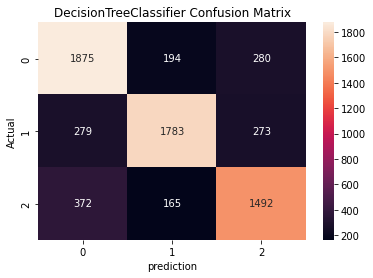

              precision    recall  f1-score   support

           0       0.77      0.81      0.79     20686
           1       0.84      0.77      0.80     21416
           2       0.74      0.77      0.75     18310

    accuracy                           0.78     60412
   macro avg       0.78      0.78      0.78     60412
weighted avg       0.79      0.78      0.78     60412

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2349
           1       0.83      0.76      0.80      2335
           2       0.73      0.74      0.73      2029

    accuracy                           0.77      6713
   macro avg       0.77      0.77      0.77      6713
weighted avg       0.77      0.77      0.77      6713



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split= 2).fit(x_train,y_train)
get_accuracy('DecisionTreeClassifier',clf,x_train, y_train, x_test, y_test)


# **random forest model**

Testing accuracy   : 82.4668553552808 %
MSE [TEST]          : 0.422910770147475
Training accuracy  : 84.70502549162417 %
MSE [TRAIN]         : 0.35024498444017743
precision :  0.824668553552808
recall    :  0.824668553552808
f1_score  :  0.824668553552808


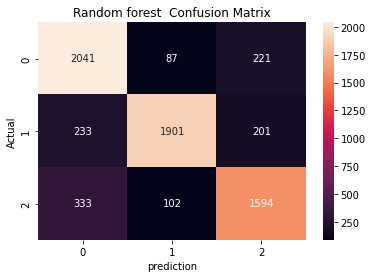

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     20686
           1       0.93      0.82      0.87     21416
           2       0.81      0.83      0.82     18310

    accuracy                           0.85     60412
   macro avg       0.85      0.85      0.85     60412
weighted avg       0.85      0.85      0.85     60412

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      2349
           1       0.91      0.81      0.86      2335
           2       0.79      0.79      0.79      2029

    accuracy                           0.82      6713
   macro avg       0.83      0.82      0.82      6713
weighted avg       0.83      0.82      0.83      6713



In [ ]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(max_depth=9,min_samples_leaf=5,min_samples_split=3).fit(x_train,y_train)
get_accuracy('Random forest ',model,x_train, y_train, x_test, y_test)


# **model 1 neural network**

In [ ]:
NN_models=[]

In [ ]:

model=Sequential()
model.add(Dense( 64 ,input_shape=(100,),activation='relu' ))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer = 'adam', loss = 'categorical_crossentropy' ,metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 64)                6464      
                                                                 
 dense_47 (Dense)            (None, 32)                2080      
                                                                 
 dense_48 (Dense)            (None, 16)                528       
                                                                 
 dense_49 (Dense)            (None, 3)                 51        
                                                                 
Total params: 9,123
Trainable params: 9,123
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train,y_train_enc,batch_size=256 ,epochs=70)


Epoch 1/70
236/236 [==============================] - 1s 3ms/step - loss: 0.5721 - accuracy: 0.7853
Epoch 2/70
236/236 [==============================] - 1s 3ms/step - loss: 0.4646 - accuracy: 0.8267
Epoch 3/70
236/236 [==============================] - 1s 3ms/step - loss: 0.4461 - accuracy: 0.8327
Epoch 4/70
236/236 [==============================] - 1s 3ms/step - loss: 0.4329 - accuracy: 0.8372
Epoch 5/70
236/236 [==============================] - 1s 3ms/step - loss: 0.4269 - accuracy: 0.8395
Epoch 6/70
236/236 [==============================] - 1s 3ms/step - loss: 0.4210 - accuracy: 0.8402
Epoch 7/70
236/236 [==============================] - 1s 3ms/step - loss: 0.4187 - accuracy: 0.8408
Epoch 8/70
236/236 [==============================] - 1s 3ms/step - loss: 0.4125 - accuracy: 0.8434
Epoch 9/70
236/236 [==============================] - 1s 3ms/step - loss: 0.4096 - accuracy: 0.8440
Epoch 10/70
236/236 [==============================] - 1s 3ms/step - loss: 0.4062 - accuracy: 0.8449

In [ ]:
pred=model.predict(x_test)
pred_list=[]
for i in pred:
  pred_list.append(np.argmax(i))
from sklearn.metrics import accuracy_score
print("test accuracy : ", accuracy_score(y_test,pred_list)*100)
print("_______________________")
print(classification_report(y_test,pred_list  ))
print("confusion  matrix")
print(confusion_matrix(pred_list, y_test))


210/210 [==============================] - 0s 1ms/step
test accuracy :  85.10353046328021
_______________________
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2349
           1       0.91      0.85      0.88      2335
           2       0.79      0.85      0.82      2029

    accuracy                           0.85      6713
   macro avg       0.85      0.85      0.85      6713
weighted avg       0.85      0.85      0.85      6713

confusion  matrix
[[2001  146  194]
 [  91 1986  109]
 [ 257  203 1726]]


# ***model 2 neural ntework***

In [1]:

model=Sequential()
model.add(Dense( 120,input_shape=(100,),activation='relu' ))

model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer = 'adam' ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])



NameError: ignored

In [ ]:
model.fit(x_train,y_train_enc,batch_size=256 ,epochs=50)

In [ ]:
pred=model.predict(x_test)
pred_list=[]
for i in pred:
  pred_list.append(np.argmax(i))
from sklearn.metrics import accuracy_score
print("test accuracy : ", accuracy_score(y_test,pred_list)*100)
print("_______________________")
print(classification_report(y_test,pred_list  ))
print("confusion  matrix")
print(confusion_matrix(pred_list, y_test))

In [ ]:
models=[]

CNN

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten
# Instantiate your model as usual
model = Sequential()
model.add(Conv2D(
                 filters=64,  
                 kernel_size=2,              
                 input_shape=(10,10,1),     
                 activation='relu')
)

model.add(Conv2D(8, kernel_size=3, activation='relu'))
model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(16, activation='relu'))
# End this multiclass model with 3 outputs and softmax
model.add(Dense(3, activation='softmax'))

model.summary ()

In [ ]:
model.compile(optimizer = 'adam' ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])
model.fit(x_train.reshape(-1,10,10,1),y_train_enc,batch_size=256 ,epochs=70)

In [ ]:

pred=model.predict(x_test.reshape(-1,10,10,1))
pred_list=[]
for i in pred:
  pred_list.append(np.argmax(i))
from sklearn.metrics import accuracy_score
print("test accuracy : ", accuracy_score(y_test,pred_list)*100)
print("_______________________")
print(classification_report(y_test,pred_list  ))
print("confusion  matrix")
print(confusion_matrix(pred_list, y_test))

In [ ]:
models.append(model)